In [1]:
# this code gets both the images and patches to trian the pre-trained model using the cross validation technique

# use this cell to import all necessary libraries

import os
# to run on GPU, comment the following tow lines 
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
import pylab
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from util import read_data_dual_input, read_patch_test, read_patch_rvs_test, gray2RGB
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import random

Using TensorFlow backend.


In [2]:
# use this cell to get all of the input parameters and paths to train and tune

# input shapes for the pretrained models(input_1 and input_2 are the image and patch inputs respectively)

input_1 = (224, 224, 3)
input_2 = (64, 64, 3)

# input parameters and paths for training

csvPath = '/home/mohammadali/Downloads/Run/Train.csv'
imagePath = '/home/mohammadali/Downloads/Run/Train-Seg-Man'
patchPath = '/home/mohammadali/Downloads/Run/Train-Patch'
inputSize = (224,224)
patchSize = (64, 64)
split_ratio = 0.2
batch_size = 32
learning_rate = 1e-6
epoch_size = 2
nodes = 1024 # number of nodes for the fc layer
drop_out = 0.5 # the layer after the fc layer
k_fold = 2

# input parameters and paths for testing

test_dir = '/home/mohammadali/Downloads/Run/Test-Seg-Man'
test_dir_patch = '/home/mohammadali/Downloads/Run/Test-Patch'
csvTest = '/home/mohammadali/Downloads/Run/Test.csv'
IMG_SIZE = 224
Patch_SIZE = 64

In [4]:
# use this cell to train the model (all of the inputs have been given in the second cell)

# preparing the data to train

random.seed(7)

train_images, train_patches, train_labels, val_images, val_patches, val_labels = \
read_data_dual_input(csvPath, imagePath, patchPath, inputSize, patchSize, split_ratio,
                     aug_rotate = 6, kfold = k_fold, outchannels = 3)
print("")
print("multiple inputs model")
print("")
for i in range(k_fold):
    print ('fold %d, image size:' % (i+1), train_images[i].shape)
    print ('fold %d, patch size:' % (i+1), train_patches[i].shape)
    print ('fold %d, label size:' % (i+1), train_labels[i].shape)
    print ('fold %d, val_image size:' % (i+1), val_images[i].shape)
    print ('fold %d, val_patch size:' % (i+1), val_patches[i].shape)
    print ('fold %d, val_label size:' % (i+1), val_labels[i].shape)
    print("")
print("")
print("making the model for the first input")

# using the pretrained model for training

conv_base_1 = VGG16(weights = 'imagenet', include_top = False, input_shape = input_1)
#conv_base_1.summary()

for layer in conv_base_1.layers:
    layer.name = layer.name + str("_1")

# Creating dictionary that maps layer names to the layers
#layer_dict = dict([(layer.name, layer) for layer in conv_base.layers])
# Getting output tensor of the last VGG layer that we want to include
#lay = layer_dict['block5_pool'].output
#print (lay)

for layer in conv_base_1.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers

#for layer in conv_base_1.layers:
#    print(layer, layer.trainable)

inp_1 = layers.Input(shape = input_1)
conv_base_out_1 = conv_base_1(inp_1)
flat_1 = layers.Flatten()(conv_base_out_1)
#print(flat_1)
print("")
print("making the model for the second input")
print("")

# using the pretrained model for training

#conv_base_2 = VGG16(weights = 'imagenet', include_top = False, input_shape = input_2)
conv_base_2 = VGG19(weights = 'imagenet', include_top = False, input_shape = input_2)
#conv_base_2 = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_2)

for layer in conv_base_2.layers:
    layer.name = layer.name + str("_2")
#conv_base_2.summary()

# Creating dictionary that maps layer names to the layers
#layer_dict = dict([(layer.name, layer) for layer in conv_base.layers])
# Getting output tensor of the last VGG layer that we want to include
#lay = layer_dict['block5_pool'].output
#print (lay)

for layer in conv_base_2.layers[:-5]:
    layer.trainable = False

# Check the trainable status of the individual layers

#for layer in conv_base_2.layers:
#    print(layer, layer.trainable)

inp_2 = layers.Input(shape = input_2)
conv_base_out_2 = conv_base_2(inp_2)
flat_2 = layers.Flatten()(conv_base_out_2)
#print(flat_2)

# making the FC layers of the model

concat = layers.merge.concatenate([flat_1, flat_2])
dense1 = layers.Dense(nodes, activation = 'relu')(concat)
dense1 = layers.Dropout(drop_out)(dense1)
output = layers.Dense(1, activation= 'sigmoid')(dense1)

# creating the model with two inputs

model = models.Model(inputs = [inp_1, inp_2], outputs = output)
#print(model.summary())

# plotting the model graph

#plot_model(model, to_file='multiple_inputs.png')

# compiling the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=learning_rate), metrics=['acc'])

# defining k-fold cross validation test harness

cvscores1 = []
cvscores2 = []
i = 1
for j in range(k_fold):
    X1 = train_images[j]
    X2 = train_patches[j]
    y = train_labels[j]
    X1_t = val_images[j]
    X2_t = val_patches[j]
    y_t = val_labels[j]

    # data augmentation

    train_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

    #val_datagen = ImageDataGenerator(rescale=1./255)

    # training the model

    print('fold %d:' % (i))
    H = model.fit_generator(
        train_datagen.flow([X1, X2], y, batch_size = batch_size),
        steps_per_epoch= len(X1) // batch_size,
        epochs = epoch_size,
        validation_data = ([X1_t, X2_t], y_t),
        validation_steps = len(X1_t) // batch_size)

    # computing the accuracy metric for this CV fold
    
    scores = model.evaluate([X1_t, X2_t], y_t, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores1.append(scores[1] * 100)
    
    # computing the AUC metric for this CV fold

    preds = model.predict([X1_t, X2_t])
    fpr, tpr, thresholds = metrics.roc_curve(y_t, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("%s: %.2f%%" % ('auc', roc_auc*100));
    cvscores2.append(roc_auc*100)
    i = i + 1
    print('');

print("tot_acc_avg: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)));
print("tot_auc_avg: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)));

# saving the model

model.save_weights('model_weights_lung_pro_cv_multiple.h5')
model.save('model_lung_pro_cv_multiple.h5')

Labels loaded: 50 positive,45 negatve.
Images loaded: 95; Masks loaded: 95

multiple inputs model

fold 1, image size: (282, 224, 224, 3)
fold 1, patch size: (282, 64, 64, 3)
fold 1, label size: (282,)
fold 1, val_image size: (288, 224, 224, 3)
fold 1, val_patch size: (288, 64, 64, 3)
fold 1, val_label size: (288,)

fold 2, image size: (288, 224, 224, 3)
fold 2, patch size: (288, 64, 64, 3)
fold 2, label size: (288,)
fold 2, val_image size: (282, 224, 224, 3)
fold 2, val_patch size: (282, 64, 64, 3)
fold 2, val_label size: (282,)


making the model for the first input

making the model for the second input

fold 1:
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
8/8 [==============================] - 6s 722ms/step - loss: 0.7304 - acc: 0.4844 - val_loss: 0.7157 - val_acc: 0.4688
Epoch 2/2
8/8 [==============================] - 3s 362ms/step - loss: 0.7426 - acc: 0.4976 - val_loss: 0.7453 - val_acc: 0.4097
acc: 40.97%
auc: 62.90%

fold 2:
Epoch 1/2
9/9 [=======================

shape of X_test: (21, 224, 224)
shape of X_testing1: (21, 224, 224, 3)
shape of X_test_patch: (21, 64, 64)
shape of X_testing2: (21, 64, 64, 3)
shape of y_test: (21,)
21/21 [==============================] - 1s 33ms/step

Predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

True labels: [0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]

[False False False  True  True  True False False False  True  True  True
  True  True  True  True  True  True False False False]


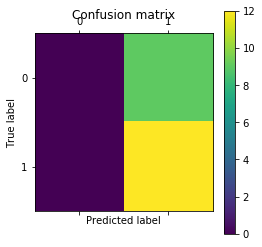

In [6]:
# use this cell to test the model (all of the inputs have been given in the second cell)

# loading the model

#model = load_model('model_lung_pro_cv_multiple.h5')
#model.summary()

# getting the images for testing

file_list2 = os.listdir(test_dir)
test_imgs = [test_dir + "/" + "{}".format(i) for i in file_list2]
#print("No. of test images = ", len(test_imgs))
    
X_test = []
for image in test_imgs:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC))
X_test = np.array(X_test)
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))
#X_test = X_test/255.0
print("shape of X_test:", X_test.shape)

X_testing1 = []
for m in range (len(X_test)):
    X_testt = X_test[m]
    X_testing1.append(gray2RGB(X_testt))
X_testing1 = np.array(X_testing1)
print("shape of X_testing1:", X_testing1.shape)

# getting the patches for testing

file_list3 = os.listdir(test_dir_patch)
test_imgs_patch = [test_dir_patch + "/" + "{}".format(i) for i in file_list3]
#print("No. of test images = ", len(test_imgs))
X_test_patch = []
for image in test_imgs_patch:
    X_test_patch.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (Patch_SIZE, Patch_SIZE), interpolation=cv2.INTER_CUBIC))

X_test_patch = np.array(X_test_patch)
print("shape of X_test_patch:", X_test_patch.shape)

X_test_final = []
for h in range (len(X_test_patch)):
    X_test_final.append(read_patch_test(X_test[h], X_test_patch[h], patch_size = (Patch_SIZE, Patch_SIZE)))
X_test_final = np.array(X_test_final)

X_testing2 = []
for m in range (len(X_test_final)):
    X_testt = X_test_final[m]
    X_testing2.append(gray2RGB(X_testt))
X_testing2 = np.array(X_testing2)
print("shape of X_testing2:", X_testing2.shape)

# getting the true labels for testing

df = pandas.read_csv(csvTest)
#print('shape of the dataframe:', df.shape)
#print(df.head(2))
na = df.loc[:,'File']
la = df.loc[:,'Progression']
na = np.array(na)
la = np.array(la)
I = np.argsort(na)
na = na[I]
la = la[I]
y_test = la
#sns.set(rc={'figure.figsize':(5,4)})
#sns.countplot (y_test)
#plt.title("Labels")
print ("shape of y_test:", y_test.shape)

# model prediction

preds_test = model.predict([X_testing1, X_testing2], verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
predictions_test = preds_test_t [:, 0]
print("")
print("Predicted labels:", predictions_test)
print("")
print("True labels:", y_test)
print("")
com = np.isclose(predictions_test, y_test.T)
print (com)
#true_prediction_number = 1 * (com == 'True')
#print(true_prediction_number)
cm = confusion_matrix(y_test, predictions_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()